In [4]:
from datetime import datetime, timezone

from lib import load_dataset
df = load_dataset(latitude=51.352139, longitude=6.622948, elevation=32.8, start=datetime(year=2025, month=3, day=1, tzinfo=timezone.utc))

In [8]:
not_full = df['level'] <= 98
df['yield'] = df['yield'].where(not_full)
df = df.drop(['level'], axis=1)

<Axes: >

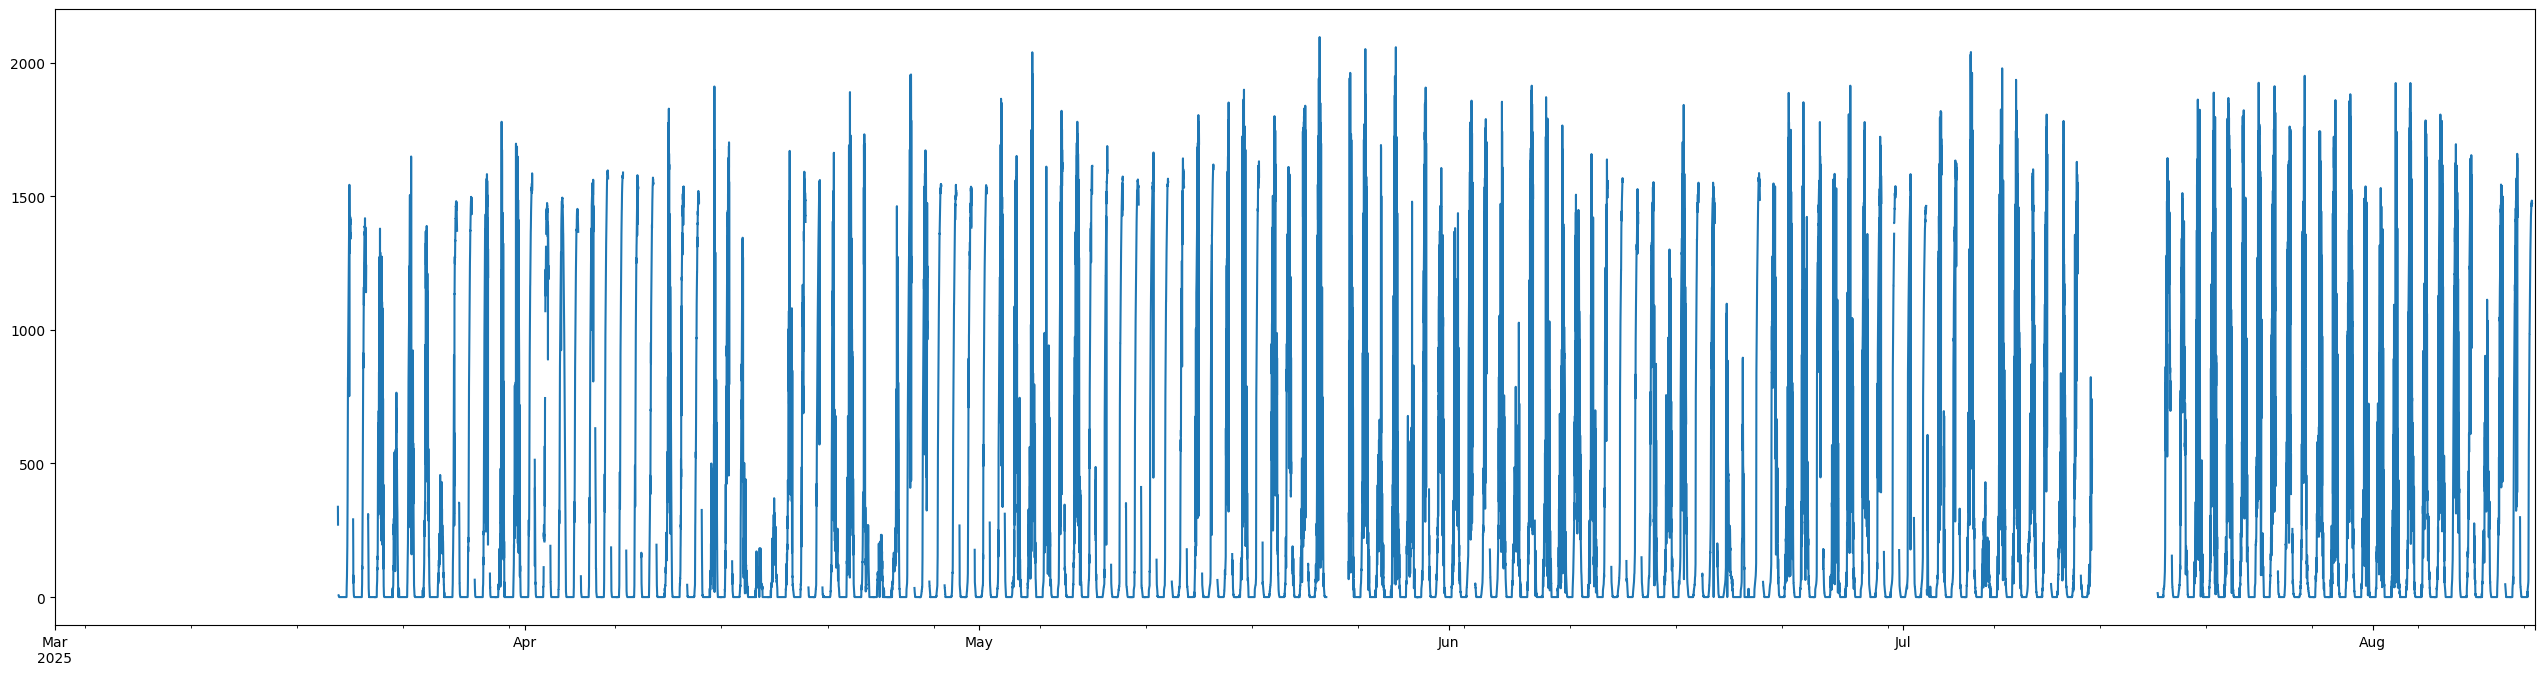

In [10]:
df['yield'].plot(figsize = (32, 8))